# Analysis of US Coastguard GPS disruption data

In [33]:
import pandas as pd
from datetime import datetime as dt

In [2]:
gps_disruption_df=pd.read_csv('gps_navcen.csv').drop('Unnamed: 0',axis=1)

In [3]:
gps_disruption_df.head()

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date
0,05/18/20222100 UTC,Port Said - Egypt - Outside Channel,NaN,User: Vessel has 2 DGPS/ and experienced GPS J...,Unknown Interference,05/25/2022
1,05/15/202208:00 CET,Belgrade,NaN,USER: After 35th Belgrade marathon many users ...,Insufficient Information,05/25/2022
2,05/13/20220653 UTC,Near Suez Canal,Marine,USER: Interference occurred until entering Sue...,Unknown Interference,05/25/2022
3,05/08/20221400 (Arabic) Egypt Standard Time (+...,juaymah Terminal,Marine,USER: Intermittent loss of signal on 3 x GPS u...,Unknown Interference,05/25/2022
4,05/05/20225:38:07 CST,Sandia Crest ALBUQUERQUE,Communications,USER: issue is intermittent affecting the foll...,GPS Testing,05/25/2022


## Analyse disruptions by date

In [35]:
gps_disruption_df['local_date']=gps_disruption_df['Disruption Date/Time']\
.apply(lambda x:dt.strptime(x[0:10],'%m/%d/%Y'))
#dt.strptime(('05/05/20225:38:07 CST')[0:10],'%m/%d/%Y')

<AxesSubplot:xlabel='local_date'>

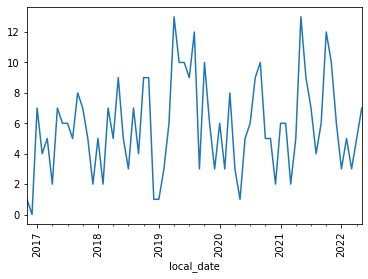

In [49]:
gps_disruption_df.resample('M', on='local_date').\
count()['Disruption Date/Time'].plot(rot=90)


## Analyse disruptions by location

In [6]:
gps_disruption_df['location_clean']=gps_disruption_df['Location'].\
apply(lambda x:x.split(',')[-1].strip().upper())
gps_disruption_df['location_clean_group_len']=gps_disruption_df['location_clean']\
.apply(lambda x: len(x))
gps_disruption_df['location_clean2']=gps_disruption_df['location_clean']


In [7]:
gps_disruption_df[gps_disruption_df['location_clean_group_len']==2]['location_clean'].unique()

array(['OR', 'AR', 'ND', 'UK', 'VA', 'WA', 'CA', 'MA', 'TX', 'NM', 'IA',
       'CO', 'FL', 'CT', 'NV', 'MD', 'AZ', 'NC', 'IN', 'NY', 'TN', 'OH',
       'PA', 'AK', 'GA', 'NJ', 'SC', 'OK', 'LA'], dtype=object)

In [8]:
gps_disruption_df

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,local_date,location_clean,location_clean_group_len,location_clean2
0,05/18/20222100 UTC,Port Said - Egypt - Outside Channel,NaN,User: Vessel has 2 DGPS/ and experienced GPS J...,Unknown Interference,05/25/2022,2022-05-18,PORT SAID - EGYPT - OUTSIDE CHANNEL,35,PORT SAID - EGYPT - OUTSIDE CHANNEL
1,05/15/202208:00 CET,Belgrade,NaN,USER: After 35th Belgrade marathon many users ...,Insufficient Information,05/25/2022,2022-05-15,BELGRADE,8,BELGRADE
2,05/13/20220653 UTC,Near Suez Canal,Marine,USER: Interference occurred until entering Sue...,Unknown Interference,05/25/2022,2022-05-13,NEAR SUEZ CANAL,15,NEAR SUEZ CANAL
3,05/08/20221400 (Arabic) Egypt Standard Time (+...,juaymah Terminal,Marine,USER: Intermittent loss of signal on 3 x GPS u...,Unknown Interference,05/25/2022,2022-05-08,JUAYMAH TERMINAL,16,JUAYMAH TERMINAL
4,05/05/20225:38:07 CST,Sandia Crest ALBUQUERQUE,Communications,USER: issue is intermittent affecting the foll...,GPS Testing,05/25/2022,2022-05-05,SANDIA CREST ALBUQUERQUE,24,SANDIA CREST ALBUQUERQUE
...,...,...,...,...,...,...,...,...,...,...
384,01/05/20174:35 UTC,Chile,Law Enforcement,User: There were large spikes in geozone alarm...,User Equipment,05/20/2019,2017-01-05,CHILE,5,CHILE
385,01/03/201711:AM CST,San Angelo Airport,Aviation,User: The GPS systems in normal mode not milit...,Unintentional Interference,05/20/2019,2017-01-03,SAN ANGELO AIRPORT,18,SAN ANGELO AIRPORT
386,01/02/20173:00 EST,North Carolina - South Carolina border,Transportation,User: GPS would say when you plug in that ther...,User Equipment,05/20/2019,2017-01-02,NORTH CAROLINA - SOUTH CAROLINA BORDER,38,NORTH CAROLINA - SOUTH CAROLINA BORDER
387,01/01/201712:00 EST,"Elizabeth, NJ",Transportation,"User: My business is located in Elizabeth, NJ....",Mapping Issue,05/20/2019,2017-01-01,NJ,2,NJ


In [9]:
disruptions_by_location=gps_disruption_df[gps_disruption_df['location_clean_group_len']!=2].groupby('location_clean2').count()['Disruption Date/Time']


In [10]:
disruptions_by_location[disruptions_by_location>1]#.plot(kind='barh')

location_clean2
ALABAMA                    2
ALASKA                     2
AT SEA                     2
BRAZIL                     5
CALIFORNIA                 3
CHINA                      4
CYPRUS                     6
EAST MEDITERRANEAN SEA     2
EAST OF MALTA              3
EASTERN MEDITERRANEAN      2
EGYPT                     23
FINLAND                    2
FLORIDA                    4
GERMANY                    3
GLOBAL                     4
GREECE                     3
INDIA                      2
IRAN                       2
ISRAEL                     3
ISTANBUL                   2
ITALY                      6
LEBANON                    4
LIBYA                      3
LIMASSOL                   9
MEDITERRANEAN SEA          2
NEW YORK                   2
OREGON                     2
PRC                        2
SAUDI ARABIA               3
SPAIN                      3
SUEZ CANAL                 2
TEXAS                      2
TURKEY                     2
UNITED STATES              

In [15]:
gps_disruption_df.query('Location in ("Worldwide","Global","At sea")')[['local_date','Location','Description']]

,local_date,Location,Description
61,2021-07-28,At sea,USER: The vessel was sailing towards port said...
108,2021-01-16,Global,CNES has detected a repetition of IODE for PRN...
139,2020-08-04,Global,User: CNES (Centre National d Etudes Spatiales...
165,2020-02-12,Worldwide,"User: In February 2020 (Feb 12th, 13th, 15th a..."
256,2019-02-01,Global,User: Thanks to Navigation and Timing Monitori...
326,2017-11-30,Global,User: GPS PRN22 orbit error started to wander ...
342,2017-09-20,Worldwide,User: It appears that the Subframe-2 IODC mess...


<AxesSubplot:ylabel='location_clean2'>

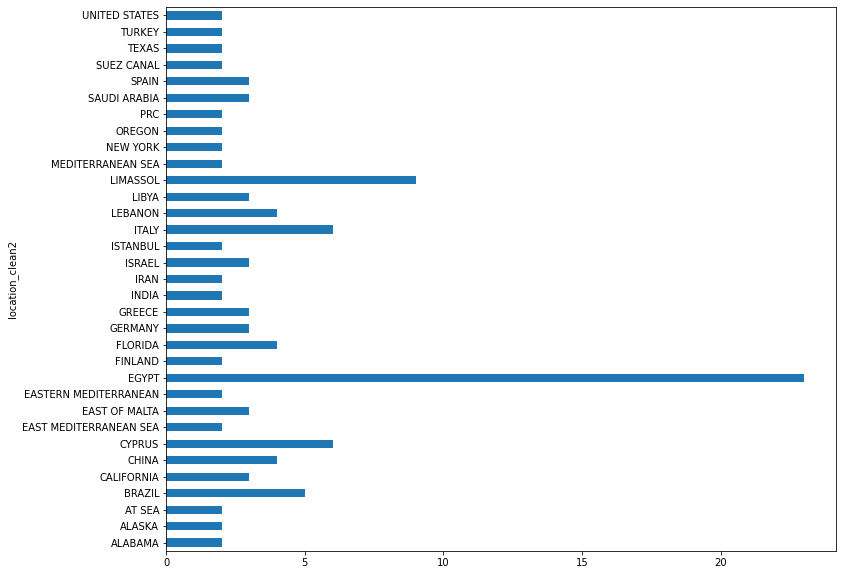

In [11]:
#def group_locations(string_x):
#    if string_x==''

disruptions_by_location[disruptions_by_location>1 ].drop(['WORLDWIDE','GLOBAL'])\
.plot(kind='barh',figsize=[12,10])

In [14]:
gps_disruption_df\
.query('location_clean2 in ("MEDITERRANEAN SEA","EASTERN MEDITERRANEAN","EAST MEDITERRANEAN SEA")')\
[['Location','Description']]

,Location,Description
80,East Mediterranean Sea,User indicated an intermittent problem that wa...
90,Eastern Mediterranean,USER: roughly 12 hours of gps spoofing upon de...
93,East Mediterranean Sea,Lost GPS signal for six-minutes from 1620 GMT ...
94,Eastern Mediterranean,"GPS jamming begins, affecting both GPS units. ..."
122,Mediterranean Sea,User: Additional vessel in area were experienc...
124,Mediterranean Sea,User: Intermittent GPS signal beginning at 013...


In [20]:
for description_str in gps_disruption_df.loc[90:95,'Description']:
    print(description_str)

USER: roughly 12 hours of gps spoofing upon departure from port Said Egypt. GPS signal rapidly shifted numerous times, position 6-8 miles off. Position dropped for 90 percent of the 12 hours. GPS aboard connected to ECDIS, RADAR,AIS, GYRO repeater panel, GMDSS suite.NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported problem. Space weather was reviewed and found unlikely to have impacted GPS performance. There were no authorized GPS tests in the area. No correlating reports from interagency partners. The report of interference is similar to that outlined by U.S. Maritime Administration in Maritime Advisory 2021-004-Various GPS Interference. User encouraged to report the issue to the nearest communication authority.
USER: For the length of our stay 23/0000 till 23/1900, we experienced intermittent reception or not at all (port approaches and alon